# Descrete Tomography


In [ ]:
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
import os

import utility as util
import astra_wrappers 
import cost_functions 
import reconstruction_alogrithms
import new_solution_generators
import postprocessing

## Loading images

(64, 64)


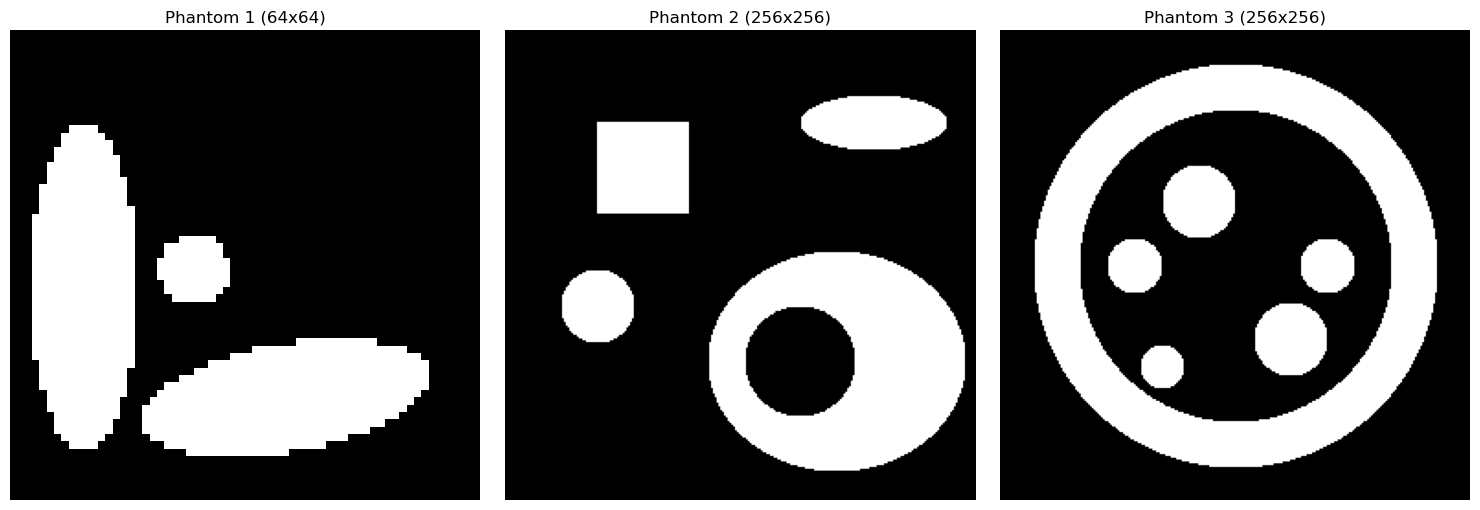

In [6]:
phantom1 = ski.io.imread(os.path.join('data', 'phantom_sz64', 'ph1.png'))
phantom1 = util.fix_img(phantom1)
phantom2 = ski.io.imread(os.path.join('data', 'phantom_sz', 'ph2.png'))
phantom2 = util.fix_img(phantom2)
phantom3 = ski.io.imread(os.path.join('data', 'phantom_sz', 'ph3.png'))
phantom3 = util.fix_img(phantom3)

images = [phantom1, phantom2, phantom3]

titles = [
    f'Phantom 1 ({phantom1.shape[0]}x{phantom1.shape[1]})',
    f'Phantom 2 ({phantom2.shape[0]}x{phantom2.shape[1]})',
    f'Phantom 3 ({phantom3.shape[0]}x{phantom3.shape[1]})'
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

## Generating Test Data

Test data is generated using the **ASTRA Toolbox** via a preprocessing function:

```python
result = preprocess_image(image, show_results=False, angles=None, M=None)  # M being the number of sensors


result = {
    "phantom": img,
    "sinogram": sinogram,
    "rec_art": rec_art,
    "rec_fbp": rec_fbp,
    "system_matrix": W,
    "angles": angles
}
```

### Projection Setup

- **Number of projections** `p ∈ {2, 3, 5, 6}`
  - For `p ∈ {2, 3, 5}`: directions uniformly sampled from `[0°, 90°]`
  - For `p = 6`: directions sampled from `[0°, 150°]`
- **Measurements per direction**:
  - Phantom 1: `96`
  - Phantoms 2 & 3: `384`

### Noise Model

- Both **noiseless** and **noisy** data were used.
- Noise: additive Gaussian `𝒩(0, σ)`, with `σ ∈ {0.5, 1.5, 5}`
- Negative values were **clipped to zero**


In [ ]:
p = [2, 3, 5, 6]
angles = []
for p_val in p:
    angles.append(np.linspace(0, np.pi/2 + np.pi/3*(p_val == 6), num=p_val, endpoint=True))
rng = np.random.default_rng(42) # For reproducibility
M = [96, 384, 384]
std = [0, 0.5, 1.5, 5]

In [ ]:
results = []

for s, projections, thetas, sensors in zip(std, p, angles, M):    
    result = preprocess_image(image, angles=thetas, M=sensors)

    # Add Gaussian noise
    sigma = 1.5
    sinogram = result['sinogram'] + rng.normal(0, sigma, result['sinogram'].shape)
    sinogram = np.clip(noisy_sino, 0, None)

    # Replace sinogram in result
    result['sinogram'] = noisy_sino

    # Evaluate both FBP and ART
    for method in ['rec_fbp', 'rec_art']:
        rec = result[method]
        rec_bin = (rec >= 0.5).astype(np.uint8)

        dice = dice_score(image, rec_bin)
        jaccard = jaccard_index(image, rec_bin)
        e1 = normalized_l1(image, rec_bin)
        e2 = normalized_l2(image, rec_bin)

        results.append({
            'method': method.upper(),
            'p': p,
            'angles_deg': angles_deg.round(2).tolist(),
            'DICE': dice,
            'Jaccard': jaccard,
            'E1 (L1)': e1,
            'E2 (L2)': e2
        })


In [19]:



def SA(image):
    """
    Simulated Annealing reconstruction.
    """
    res = astra_wrappers.preprocess_image(image)

    # --- Parameters---
    params = {
        "T_start": 0.1,
        "cooling_rate": 0.99,
        "max_iter": 50000,
        "area_threshold": 0.5,
        "epsilon": 0.00001,
        "verbose": False,
        "lambda_tv": 0.000,
        "boundary_recalc_freq" : 100
    }

    X0 = astra_wrappers.calculate_X0(res["sinogram"], res["angles"], res["rec_fbp"])

    neighbour_function = new_solution_generators.DeterioratingHammingDistance(
        max_iter=params["max_iter"],
        h_min=1,
        h_max=3
    )

    SA = reconstruction_alogrithms.SimulatedAnnealing(
        X0=X0,
        cost_function=cost_functions.l2_norm,
        cost_function_args=(res["system_matrix"], res["sinogram"].ravel()),
        neighbour_function=neighbour_function,
        params=params
    )

    SA.estimate_starting_temperature(100)
        
    best_img, best_cost, cost_history = SA.run()
    print(f"Best cost: {best_cost}")

SA(phantom1)



Best cost: 11.418332531968675
